In [1]:
from pyspark.sql import SparkSession

import pyspark.sql.functions as spf

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder.appName("anokhin").getOrCreate()
spark

## Model Based Collaborative filtering

### Собираем данные на Spark и сохраняем как pandas dataframe

In [3]:
data = (
    spark.read.json("/user/anokhin/week03/*/data.json")
        .filter(spf.col("time") > 0.8)
        .select("user", "track", "time")
        .groupBy("user", "track")
        .agg(
            spf.avg("time").alias("time")
        )
        .withColumn("test", spf.rand() > 0.7)
)

data.limit(10).show()

+----+-----+----+-----+
|user|track|time| test|
+----+-----+----+-----+
|8919|38622|0.99| true|
|2803|12040| 1.0| true|
|6263|19518| 1.0|false|
|5109| 7098| 1.0|false|
|  30| 1046| 1.0| true|
|3300| 4460| 1.0|false|
|9626|29437|0.91| true|
|2910|  559| 1.0|false|
|9924|18350| 1.0|false|
|1925|  511| 1.0|false|
+----+-----+----+-----+



In [4]:
data.toPandas().to_json("/home/anokhin/data/week04.json", orient="records", lines=True)

### Обучаем ALS на Spark и сохраняем рекомендации

In [5]:
als = ALS(
    rank=50,
    maxIter=25, 
    regParam=0.1, 
    userCol="user", 
    itemCol="track", 
    ratingCol="time",
    coldStartStrategy="drop",
).fit(data.filter(spf.col("test") == False))

In [6]:
predictions = als.transform(data.filter(spf.col("test") == True))

evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="time",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.10660422882594421


In [7]:
(
    als
        .recommendForAllUsers(100)
        .select(
            spf.col("user"),
            spf.col("recommendations.track").alias("tracks")
        )
).toPandas().to_json("/home/anokhin/data/recomendations_als.json", orient="records", lines=True)

### Train LightFM

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.special as sp

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
data = pd.read_json("/Users/n.anokhin/Desktop/week04.json", lines=True)

data.head()

,user,track,time,test
0,722,48555,0.86,True
1,1514,401,1.00,False
2,4135,43182,0.89,True
3,4677,1927,0.98,False
4,7121,27807,0.95,False


In [5]:
user_counts = data.loc[~data["test"], "user"].value_counts()
users = set(user_counts[user_counts >= 5].index.values)

len(users)

10000

In [6]:
track_counts = data.loc[~data["test"], "track"].value_counts()
tracks = set(track_counts[track_counts >= 5].index.values)

len(tracks)

8264

In [7]:
train_data = data[~data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]
test_data = data[data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]

len(train_data), len(test_data)

(121481, 48688)

In [8]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [12]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [20]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
best_params = study.best_params

best_params

[I 2023-10-12 15:53:11,288] A new study created in memory with name: no-name-208d3ccb-8ee9-4863-b0ac-becc38dd828d
[I 2023-10-12 15:53:16,380] Trial 0 finished with value: 0.016688581556081772 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.001, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.001}. Best is trial 0 with value: 0.016688581556081772.
[I 2023-10-12 15:53:21,507] Trial 1 finished with value: 0.017123496159911156 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.001, 'max_sampled': 10, 'user_alpha': 0.001, 'item_alpha': 0.001}. Best is trial 1 with value: 0.017123496159911156.
[I 2023-10-12 15:53:25,614] Trial 2 finished with value: 0.01660766825079918 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.001, 'max_sampled': 10, 'user_alpha': 0.001, 'item_alpha': 0.0}. Best is trial 1 with value: 0.017123496159911156.
[I 2023-10-12 15:53:30,000] Trial 3 finished with value: 0.0021138868760317564 and para

{'loss': 'warp',
 'no_components': 30,
 'learning_rate': 0.001,
 'max_sampled': 10,
 'user_alpha': 0.001,
 'item_alpha': 0.001}

In [22]:
best_params = {
    'loss': 'warp',
    'no_components': 50,
    'learning_rate': 0.01,
    'max_sampled': 100,
    'user_alpha': 0.0,
    'item_alpha': 0.01
}

In [23]:
model, precisions_at = fit_model(
    epochs=100,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.01708303950726986 +/- 0.000990550136266595
1:	0.021604126319289207 +/- 0.0011922295784725415
2:	0.025022758170962334 +/- 0.0013326977024009366
3:	0.02839081734418869 +/- 0.0014235505575504112
4:	0.03296247869729996 +/- 0.0015331738918200563
5:	0.037261053919792175 +/- 0.0016148935986347091
6:	0.04201476648449898 +/- 0.0016987974596597481
7:	0.046687569469213486 +/- 0.0017684203123861113
8:	0.05114797502756119 +/- 0.0018359769423054602
9:	0.054768893867731094 +/- 0.0018852812275891894
10:	0.0583898089826107 +/- 0.0019394252531801436
11:	0.061525240540504456 +/- 0.001971808658464573
12:	0.06517649441957474 +/- 0.0020153400326602283
13:	0.06833215802907944 +/- 0.0020441386463819016
14:	0.07192272692918777 +/- 0.0020751568084213246
15:	0.07486598938703537 +/- 0.0021041075727456044
16:	0.07797107845544815 +/- 0.002124720895264909
17:	0.08103571087121964 +/- 0.0021522168295994046
18:	0.08417113870382309 +/- 0.0021839283342980007
19:	0.08735714107751846 +/- 0.0022108191909464554
20:	0.09

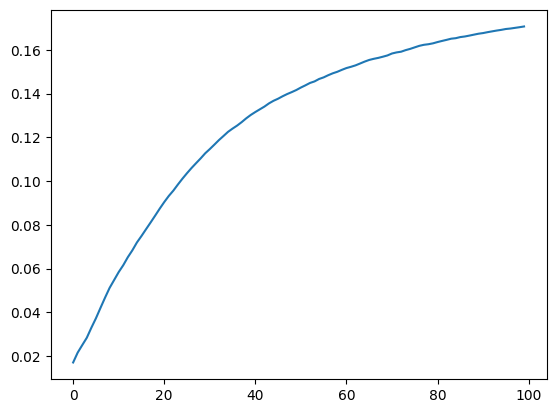

In [24]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

In [25]:
predictions = model.predict(
    test_data["user"].map(dataset.mapping()[0]).values,
    test_data["track"].map(dataset.mapping()[2]).values,
)

rmse = np.sqrt(((predictions - test_data["time"].values) * (predictions - test_data["time"].values)).mean())
rmse # Q: ???

1.0068346544262243

## Save track embeddings

In [26]:
BOTIFY_DATA_DIR = "/Users/n.anokhin/Projects/recsys-course/botify/data/"

In [27]:
biases, embeddings = model.get_item_representations()

In [28]:
track_meta = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [29]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [30]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir="/Users/n.anokhin/Desktop/tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [31]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [32]:
predictions = model.predict(1, np.arange(dataset.item_features_shape()[0]), num_threads=30)
predictions

array([ 0.5702357 , -0.7637996 ,  0.01772008, ..., -1.3007761 ,
       -0.85846007, -1.3485311 ], dtype=float32)

In [33]:
with open(BOTIFY_DATA_DIR + "recommendations_lfm.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": top.tolist()
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 827.71it/s]
